In [2]:
import os
import numpy as np
import glob
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from pyproj import Geod
import pickle

# Data Import

In [3]:
path = '/glade/work/stevenxu/CESM1'
all_files = glob.glob(os.path.join(path, "*.nc"))
print(all_files) 
datasets = {}
for file in all_files:
    varname = os.path.basename(file).split("_")[0]
    datasets[varname] = xr.open_dataset(file)

['/glade/work/stevenxu/CESM1/PREC_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/ROFF_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/SHF_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/MELT_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/EVAP_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/IOFF_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/PD_preindustrial_spinup.nc']


In [4]:
PREC = datasets["PREC"].isel(time=slice(-240,None))
ROFF = datasets["ROFF"].isel(time=slice(-240,None))
SHF  = datasets["SHF"].isel(time=slice(-240,None))
MELT = datasets["MELT"].isel(time=slice(-240,None))
EVAP = datasets["EVAP"].isel(time=slice(-240,None))
IOFF = datasets["IOFF"].isel(time=slice(-240,None))
PD   = datasets["PD"].isel(time=slice(-240,None))

In [5]:
prec = PREC['PREC_F']
roff = ROFF['ROFF_F']
melt = MELT['MELT_F']
evap = EVAP['EVAP_F']
ioff = IOFF['IOFF_F']

# Calculate freshwater flux
FWF = (roff + ioff + melt + prec + evap).rename('FWF')
FWF = FWF.assign_attrs({
    'long_name': 'Total Freshwater Flux',
    'units': 'kg/m^2/s',
    'components': 'ROFF_F + IOFF_F + MELT_F + PREC_F + EVAP_F'
})
FWF = ROFF.assign(FWF=FWF)
FWF = FWF.drop_vars('ROFF_F')

# convert density unit from g/cm^3 to kg/m^3
PD["PD"] = PD["PD"] * 1000.0
PD["PD"].attrs["units"] = "kg/m^3"


In [6]:
SHF

<xarray.Dataset> Size: 12MB
Dimensions:      (time: 240, d2: 2, nlat: 116, nlon: 100)
Coordinates:
  * time         (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG        (nlat, nlon) float64 93kB ...
    ULAT         (nlat, nlon) float64 93kB ...
    TLONG        (nlat, nlon) float64 93kB ...
    TLAT         (nlat, nlon) float64 93kB ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (time, d2) object 4kB ...
    REGION_MASK  (nlat, nlon) float64 93kB ...
    UAREA        (nlat, nlon) float64 93kB ...
    TAREA        (nlat, nlon) float64 93kB ...
    SHF          (time, nlat, nlon) float32 11MB ...
Attributes: (12/13)
    title:           restart_spunup_v15
    history:         Thu Mar 27 17:21:35 2025: ncrcat -v SHF,TAREA,UAREA,REGI...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 58852 2014-04-04 21:28:27Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2022-07-29 at 12:56:18.1
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    9485645
    tavg_sum:        2678400.0
    tavg_sum_qflux:  2678400.0
    NCO:             netCDF Operators version 5.2.6 (Homepage = http://nco.sf...

In [7]:
density_data = PD
hf_datasets = SHF
wf_datasets = FWF

In [8]:
wf_datasets

<xarray.Dataset> Size: 12MB
Dimensions:      (time: 240, d2: 2, nlat: 116, nlon: 100)
Coordinates:
  * time         (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG        (nlat, nlon) float64 93kB ...
    ULAT         (nlat, nlon) float64 93kB ...
    TLONG        (nlat, nlon) float64 93kB ...
    TLAT         (nlat, nlon) float64 93kB ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (time, d2) object 4kB ...
    REGION_MASK  (nlat, nlon) float64 93kB ...
    UAREA        (nlat, nlon) float64 93kB ...
    TAREA        (nlat, nlon) float64 93kB ...
    FWF          (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
Attributes: (12/13)
    title:           restart_spunup_v15
    history:         Thu Mar 27 17:21:35 2025: ncrcat -v ROFF_F,TAREA,UAREA,R...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 58852 2014-04-04 21:28:27Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2022-07-29 at 12:56:18.1
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    9485645
    tavg_sum:        2678400.0
    tavg_sum_qflux:  2678400.0
    NCO:             netCDF Operators version 5.2.6 (Homepage = http://nco.sf...

# Calculate F surf

- Overall mean alpha: 0.00019915005771352584
- Overall mean beta: 0.000746301819876489

In [9]:
def compute_fsurf(
				density_data, hf_datasets, wf_datasets,
				cp=3990.0, rho0=1027.0, rho_fw=1000.0, S0=35.0,
				last_n_months=None):

	HF = hf_datasets['SHF']  # W m^-2, 
	WF = wf_datasets['FWF']     # kg m^-2 s^-1, 
	area = wf_datasets["TAREA"]

	rho = density_data['PD']
	alpha = 0.0001391022569339093
	beta = 0.0007600059551595953

	if last_n_months is not None:
		HF  = HF.isel(time=slice(-last_n_months, None))
		WF = WF.isel(time=slice(-last_n_months, None))

    # f_surf = -(alpha/cp) * f_heat  - (rho0/rho_fw) * beta * S0 * f_water
	fsurf = (alpha / cp) * HF  +  (rho0 / rho_fw) * beta * S0 * WF
	fsurf = fsurf.assign_attrs(
		long_name="Buoyancy-relevant surface forcing (Eq. 5)",
		description="(alpha/cp)*f_heat + (rho0/rho_fw)*beta*S0*f_water",
		units="",
		cp=cp, rho0=rho0, rho_fw=rho_fw, S0=S0
	)

	heat_comp = (alpha / cp) * HF
	fw_comp = (rho0 / rho_fw) * beta * S0 * WF

	return xr.Dataset(dict(fsurf=fsurf, rho=rho, heat_comp=heat_comp, fw_comp=fw_comp, area=area))

Fsurf_data = compute_fsurf(
	density_data = density_data,
	hf_datasets = hf_datasets,
	wf_datasets = wf_datasets,
	last_n_months=240
)

# Drop the z_t coordinate 
Fsurf_data = Fsurf_data.isel(z_t=0).drop_vars('z_t')


Fsurf_data

<xarray.Dataset> Size: 45MB
Dimensions:    (time: 240, nlat: 116, nlon: 100)
Coordinates:
  * time       (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG      (nlat, nlon) float64 93kB 325.1 328.7 332.3 ... 318.7 320.1 321.5
    ULAT       (nlat, nlon) float64 93kB -78.73 -78.73 -78.73 ... 68.42 68.4
    TLONG      (nlat, nlon) float64 93kB 323.3 326.9 330.5 ... 317.8 319.3 320.8
    TLAT       (nlat, nlon) float64 93kB -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
Dimensions without coordinates: nlat, nlon
Data variables:
    fsurf      (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    rho        (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    heat_comp  (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    fw_comp    (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    area       (nlat, nlon) float64 93kB ...

# Calculating Fgen at single timepoint

### Create density class list
Take max and min in rho values, and slice with interval 0.01

In [10]:
ds = Fsurf_data
da = ds['rho'].isel(time=0)
rho_min = float(da.min())
rho_max = float(da.max())

In [11]:
step_size = 0.05
rho_classes = np.arange(rho_min, rho_max + step_size, step_size)

### Dataset for area at each grid cell

In [20]:
area = Fsurf_data["area"]/1e4
area 

<xarray.DataArray 'area' (nlat: 116, nlon: 100)> Size: 93kB
array([[1.15361399e+10, 1.15117150e+10, 1.14636754e+10, ...,
        1.14636754e+10, 1.15117150e+10, 1.15361399e+10],
       [1.40569203e+10, 1.40569203e+10, 1.40569203e+10, ...,
        1.40569203e+10, 1.40569203e+10, 1.40569203e+10],
       [1.57981918e+10, 1.57981918e+10, 1.57981918e+10, ...,
        1.57981918e+10, 1.57981918e+10, 1.57981918e+10],
       ...,
       [3.13469275e+09, 3.12916411e+09, 3.11805646e+09, ...,
        3.11805646e+09, 3.12916411e+09, 3.13469275e+09],
       [2.95886339e+09, 2.95275850e+09, 2.94053488e+09, ...,
        2.94053488e+09, 2.95275850e+09, 2.95886339e+09],
       [2.77250146e+09, 2.76588076e+09, 2.75266376e+09, ...,
        2.75266376e+09, 2.76588076e+09, 2.77250146e+09]])
Coordinates:
    ULONG    (nlat, nlon) float64 93kB 325.1 328.7 332.3 ... 318.7 320.1 321.5
    ULAT     (nlat, nlon) float64 93kB -78.73 -78.73 -78.73 ... 68.49 68.42 68.4
    TLONG    (nlat, nlon) float64 93kB 323.3 326.9 330.5 ... 317.8 319.3 320.8
    TLAT     (nlat, nlon) float64 93kB -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
Dimensions without coordinates: nlat, nlon

### Integration

Group by density intervals and adding up the area-weighted fsurf

In [13]:
# create a mask to filter by latitude
lat   = Fsurf_data["TLAT"].stack(points=("nlat","nlon"))
mask_pts = lat.where(lat > 45, drop=True).points

# stack or flatten data into 1d array
fsurf = Fsurf_data["fsurf"].stack(points=("nlat","nlon")).sel(points=mask_pts)
rho   = Fsurf_data["rho"].stack(points=("nlat","nlon")).sel(points=mask_pts)
area  = area.stack(points=("nlat","nlon")).sel(points=mask_pts)

# weighted
weighted_fsurf = fsurf * area

# unstack back to original shape
weighted_fsurf = weighted_fsurf.unstack("points")  
rho = rho.unstack("points") 

In [14]:
weighted_fsurf

<xarray.DataArray (time: 240, nlat: 40, nlon: 100)> Size: 8MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * nlat     (nlat) int64 320B 76 77 78 79 80 81 82 ... 110 111 112 113 114 115
  * nlon     (nlon) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * time     (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG    (nlat, nlon) float64 32kB nan nan nan nan ... 318.7 320.1 321.5
    ULAT     (nlat, nlon) float64 32kB nan nan nan nan ... 68.49 68.42 68.4
    TLONG    (nlat, nlon) float64 32kB nan nan nan nan ... 317.8 319.3 320.8
    TLAT     (nlat, nlon) float64 32kB nan nan nan nan ... 68.36 68.26 68.21

In [15]:
# Summing up by dentisy interval
Fgen_org = weighted_fsurf.groupby_bins(rho, bins=rho_classes, right=False).sum(dim=("nlat","nlon")) / step_size /1e6

# adding centered coordinate for density intervals
rho_centers = (rho_classes[:-1] + rho_classes[1:]) / 2

# organizing
Fgen = Fgen_org.assign_coords(rho_center=("rho_bins", rho_centers))
Fgen = Fgen.rename(rho_bins="rho_intervals")
Fgen = Fgen.rename('Fgen')
Fgen

<xarray.DataArray 'Fgen' (rho_intervals: 515, time: 240)> Size: 989kB
array([[-1.20018   ,  0.01125952,  0.22322514, ...,         nan,
                nan, -2.10199891],
       [        nan,         nan,         nan, ...,         nan,
        -3.12800525,         nan],
       [        nan,         nan,         nan, ..., -3.46779239,
        -1.94958837,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * time           (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
  * rho_intervals  (rho_intervals) int64 4kB 0 1 2 3 4 5 ... 510 511 512 513 514
    rho_center     (rho_intervals) float64 4kB 1.004e+03 1.004e+03 ... 1.029e+03

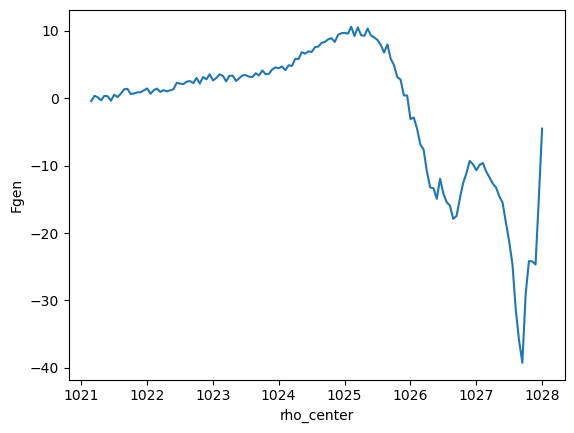

In [19]:
Fgen.mean(dim ='time').isel(rho_intervals = slice(350,600)).plot(x = 'rho_center')